# Pipeline for High-z Radio Galaxies 09: SHAP values for meta models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the meta-learners used for predictions.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
use_high_z_sources  = False
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test_Train  (Validation corresponds to final testing set)
if not use_high_z_sources:
    if used_area == 'HETDEX':
        subset_str = f'_{HETDEX_subset}'
    if used_area != 'HETDEX':
        subset_str = ''
elif use_high_z_sources:
    subset_str     = ''

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect', ]
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
model_cols = ['band_num', 'W4mag', 'g_r', 'r_i', 'r_J', 'i_z', 'i_y', 'z_y', 'z_W2', 'y_J',
              'y_W1', 'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4', 'g_i', 'r_z',
              'z_W1', 'K_W3', 'K_W4', 'W2_W3', 'Kmag', 'g_W2', 'r_y', 'g_W1']

In [9]:
feats_2_select_S82    = ['is_AGN', 'is_gal', 'is_str', 'Z', 'zsp', 'LOFAR_detect', 'is_SDSS_QSO', 'is_SDSS_gal'] + model_cols
feats_2_select_HETDEX = ['is_AGN', 'is_gal', 'is_str', 'Z', 'zsp', 'LOFAR_detect', 'is_SDSS_QSO', 'is_SDSS_gal'] + model_cols
feats_2_select_COSMOS = ['is_AGN', 'is_gal', 'is_str', 'Z', 'zsp', 'LOFAR_detect', 'is_SDSS_QSO', 'is_SDSS_gal'] + model_cols

feats_2_select        = {'S82': feats_2_select_S82, 'HETDEX': feats_2_select_HETDEX, 'COSMOS': feats_2_select_COSMOS}
features_2_select     = feats_2_select[used_area]

In [10]:
# full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').loc[:, features_2_select]
# full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df', colums=features_2_select)

In [11]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [12]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [13]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

In principle, select sources predicted to be either radio AGN or radio SFG over the subset not used for trainin stages.

In [14]:
if use_high_z_sources:  # Only use high-z AGN
    # filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [15]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
        print('Shape of used data in HETDEX')
        print('-' * 65)
        print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
        print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
        print(f'Training data:                                    {train_df.shape}')
        print(f'Testing data:                                     {test_df.shape}')
        if use_calibration:
            print(f'Calibration data:                                 {calibration_df.shape}')
        print(f'Validation data:                                  {validation_df.shape}')
        print('-' * 65)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df, 'Calibration': calibration_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (118734, 38)
Data for Modeling (Train, Test, and Calibration): (94987, 38)
Training data:                                    (75989, 38)
Testing data:                                     (9499, 38)
Calibration data:                                 (9499, 38)
Validation data:                                  (23747, 38)
-----------------------------------------------------------------

Using Validation data from HETDEX


In [16]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [17]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [18]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df
    filter_selection   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

In [19]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')
print(f'From the total, {np.sum(full_catalog_df.loc[:, "class"] == 1)} are confirmed AGN.')
print(f'From the total, {np.sum(full_catalog_df.loc[:, "class"] == 0)} are confirmed SFG.')
print(f'From the total, {np.sum(full_catalog_df.loc[:, "LOFAR_detect"] == 1)} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 1)} AGN,\
 {np.sum((full_catalog_df.loc[:, "class"] == 1) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 0)} SFG,\
 {np.sum((full_catalog_df.loc[:, "class"] == 0) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')

Full used dataset size:              (23747, 33)
--------------------------------------------------
Thus, it has 23,747 sources and 33 features.
From the total, 10108 are confirmed AGN.
From the total, 13639 are confirmed SFG.
From the total, 3668 have radio (LOFAR-like) detection.
From the 10108 AGN, 1664 have radio (LOFAR-like) detection.
From the 13639 SFG, 2004 have radio (LOFAR-like) detection.


### Load models

In [20]:
if load_models_flag:
    if use_zeroth_model:
        star_clf          = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf      = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_SFG_clf           = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #  AGN/galaxy
    cal_AGN_SFG_clf       = load(gv.models_path + gv.cal_AGN_gal_model)  # AGN/galaxy calibrated model
    # radio_det_clf         = pyc.load_model(gv.models_path + gv.radio_model)  # Radio detection for AGN
    # cal_radio_det_clf     = load(gv.models_path + gv.cal_radio_model)  # calibrated model radio detection for AGN
    # redshift_reg          = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample

    radio_det_AGN_clf     = pyc.load_model(gv.models_path + gv.radio_model)  # Radio detection for AGN
    cal_radio_det_AGN_clf = load(gv.models_path + gv.cal_radio_model)  # calibrated model radio detection for AGN
    
    radio_det_SFG_clf     = pyc.load_model(gv.models_path + gv.radio_galaxies_model)  # Radio detection for galaxies
    cal_radio_det_SFG_clf = load(gv.models_path + gv.cal_radio_gals_model)  # calibrated model radio detection for galaxie
    
    redshift_reg_rAGN     = pyr.load_model(gv.models_path + gv.full_z_model)  # Redshift prediction for radio-AGN
    redshift_reg_rSFG     = pyr.load_model(gv.models_path + gv.z_radio_galaxies_model)  # Redshift prediction for radio-galaxies

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [21]:
if use_zeroth_model:
    threshold_star_logit  = np.log(gv.star_thresh  / (1 - gv.star_thresh))
threshold_AGN_logit       = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_AGN_logit = np.log(gv.radio_thresh / (1 - gv.radio_thresh))
threshold_radio_SFG_logit = np.log(gv.radio_gals_thresh / (1 - gv.radio_gals_thresh))

#### Predictions

In [22]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [23]:
# full_catalog_df = pyc.predict_model(AGN_SFG_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
# full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
# full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)
# 
# pred_probs      = cal_AGN_SFG_clf.predict(full_catalog_df.loc[:, 'Score_AGN'])
# cal_class       = np.array(pred_probs >= gv.cal_AGN_thresh).astype(int)
# full_catalog_df['Prob_AGN']       = pred_probs
# full_catalog_df['pred_class_cal'] = cal_class

In [24]:
# full_catalog_df = pyc.predict_model(radio_det_AGN_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
# full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio_AGN', 'Score_1': 'Score_radio_AGN'})
# full_catalog_df.loc[:, 'Score_radio_AGN'] = np.around(full_catalog_df.loc[:, 'Score_radio_AGN'], decimals=6)
# 
# pred_probs      = cal_radio_det_AGN_clf.predict(full_catalog_df.loc[:, 'Score_radio_AGN'])
# cal_class       = np.array(pred_probs >= gv.cal_radio_thresh).astype(int)
# full_catalog_df['Prob_radio_AGN']     = pred_probs
# full_catalog_df['pred_radio_AGN_cal'] = cal_class

In [25]:
# full_catalog_df = pyc.predict_model(radio_det_SFG_clf, data=full_catalog_df, probability_threshold=gv.radio_gals_thresh, raw_score=True, round=10)
# full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio_SFG', 'Score_1': 'Score_radio_SFG'})
# full_catalog_df.loc[:, 'Score_radio_SFG'] = np.around(full_catalog_df.loc[:, 'Score_radio_SFG'], decimals=6)
# 
# pred_probs      = cal_radio_det_SFG_clf.predict(full_catalog_df.loc[:, 'Score_radio_SFG'])
# cal_class       = np.array(pred_probs >= gv.cal_radio_gals_thresh).astype(int)
# full_catalog_df['Prob_radio_SFG']     = pred_probs
# full_catalog_df['pred_radio_SFG_cal'] = cal_class

In [26]:
# full_catalog_df = pyr.predict_model(redshift_reg_rAGN, data=full_catalog_df, round=8)
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z_rAGN'})
# full_catalog_df.loc[:, 'pred_Z_rAGN'] = np.around(full_catalog_df.loc[:, 'pred_Z_rAGN'], decimals=4)

In [27]:
# full_catalog_df = pyr.predict_model(redshift_reg_rSFG, data=full_catalog_df, round=8)
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z_rSFG'})
# full_catalog_df.loc[:, 'pred_Z_rSFG'] = np.around(full_catalog_df.loc[:, 'pred_Z_rSFG'], decimals=4)

In [28]:
full_catalog_df = gf.predict_AGN_gal(full_catalog_df, AGN_SFG_clf,  cal_AGN_SFG_clf,
                                      gv.AGN_thresh, gv.cal_AGN_thresh, raw_score=True)

In [29]:
full_catalog_df = gf.predict_radio_det(full_catalog_df, radio_det_AGN_clf, cal_radio_det_AGN_clf,
                                       gv.radio_thresh, gv.cal_radio_thresh, raw_score=True,
                                       cols_out=['pred_radio_AGN', 'Score_radio_AGN', 'Prob_radio_AGN', 'pred_radio_AGN_cal'])

In [30]:
full_catalog_df = gf.predict_radio_det(full_catalog_df, radio_det_SFG_clf, cal_radio_det_SFG_clf,
                                        gv.radio_gals_thresh, gv.cal_radio_gals_thresh, raw_score=True,
                                       cols_out=['pred_radio_SFG', 'Score_radio_SFG', 'Prob_radio_SFG', 'pred_radio_SFG_cal'])

In [31]:
full_catalog_df = gf.predict_z(full_catalog_df, redshift_reg_rAGN, cols_out=['pred_Z_rAGN'])

In [32]:
full_catalog_df = gf.predict_z(full_catalog_df, redshift_reg_rSFG, cols_out=['pred_Z_rSFG'])

In [33]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)

In [34]:
full_catalog_df['pred_radio_SFG'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio_SFG'] == 1)

Now, select sources predicted (from calibrated models) to be rAGN and/or rSFG (depending on model to study)

In [35]:
full_catalog_df.columns.values

array(['is_str', 'Z', 'LOFAR_detect', 'band_num', 'W4mag', 'g_r', 'r_i',
       'r_J', 'i_z', 'i_y', 'z_y', 'z_W2', 'y_J', 'y_W1', 'y_W2', 'J_H',
       'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4', 'g_i', 'r_z', 'z_W1',
       'K_W3', 'K_W4', 'W2_W3', 'Kmag', 'g_W2', 'r_y', 'g_W1', 'class',
       'radio_AGN', 'pred_star', 'Score_no_star', 'pred_class',
       'Score_AGN', 'Prob_AGN', 'pred_class_cal', 'pred_radio_AGN',
       'Score_radio_AGN', 'Prob_radio_AGN', 'pred_radio_AGN_cal',
       'pred_radio_SFG', 'Score_radio_SFG', 'Prob_radio_SFG',
       'pred_radio_SFG_cal', 'pred_Z_rAGN', 'pred_Z_rSFG'], dtype=object)

In [36]:
filter_pred_AGN  = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1)
filter_pred_SFG  = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0)

In [37]:
filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                   np.array(full_catalog_df.loc[:, 'pred_radio_AGN_cal'] == 1)
filter_pred_rSFG = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0) &\
                   np.array(full_catalog_df.loc[:, 'pred_radio_SFG_cal'] == 1)

In [38]:
filter_pred_known = filter_pred_AGN | filter_pred_SFG
filter_pred_radio = filter_pred_rAGN | filter_pred_rSFG

In [39]:
def find_best_threshold(y_true, y_probs, beta=1.0):
    from sklearn.metrics import fbeta_score
    thresholds     = np.linspace(0, 1, 1001)  # Try thresholds from 0.0 to 1.0
    best_threshold = 0.5
    best_score     = 0.0

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score  = fbeta_score(y_true, y_pred, beta=beta)
        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold, best_score

In [40]:
full_catalog_df = full_catalog_df.loc[filter_pred_known]

In [41]:
np.sum(filter_pred_rAGN)

1783

In [42]:
np.sum(filter_pred_rSFG)

2005

In [43]:
np.sum(filter_pred_radio)

3788

Separate samples for each application of SHAP

In [44]:
data_AGN       = full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1)]
data_SFG       = full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0)]
data_radio_AGN = full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                     np.array(full_catalog_df.loc[:, 'pred_radio_AGN_cal'] == 1)]
data_radio_SFG = full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0) &\
                                     np.array(full_catalog_df.loc[:, 'pred_radio_SFG_cal'] == 1)]

In [45]:
print(np.shape(full_catalog_df))
print(np.shape(data_AGN))
print(np.shape(data_SFG))
print(np.shape(data_radio_AGN))
print(np.shape(data_radio_SFG))

(23747, 49)
(10292, 49)
(13455, 49)
(1783, 49)
(2005, 49)


---

## Use SHAP

Flags to run on each meta learner.

In [46]:
run_shap_AGN_meta    = True
run_shap_radio_meta  = True
run_shap_z_meta      = True
run_shap_high_z_meta = True

In [47]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [48]:
if run_shap_AGN_meta:
    model_name_AGN = type(AGN_SFG_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [49]:
if run_shap_AGN_meta:
    base_sample_size_AGN = 25000
    sample_size_AGN = np.nanmin([np.shape(full_catalog_df)[0], base_sample_size_AGN])
    print(f'Number of selected elements: {sample_size_AGN:,}')

Number of selected elements: 23,747


In [50]:
if run_shap_AGN_meta:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_SFG_clf)

In [51]:
if run_shap_AGN_meta:
    reduced_data_AGN    = full_catalog_df.sample(n=sample_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class_cal']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_SFG_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns

,class,pred_class_cal
count,23747.000000,23747.000000
mean,0.425654,0.433402
std,0.494452,0.495555
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Use FastTreeSHAP package

In [52]:
if run_shap_AGN_meta:
    explainer_AGN_meta = fasttreeshap.TreeExplainer(AGN_SFG_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=None, feature_perturbation='tree_path_dependent',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [53]:
if run_shap_AGN_meta:
    print('Working with meta-model')
    shap_values_AGN_meta = explainer_AGN_meta(reduced_data_AGN_df, check_additivity=False)

Working with meta-model


In [54]:
if run_shap_AGN_meta:
    print(explainer_AGN_meta.expected_value)
    print(np.exp(explainer_AGN_meta.expected_value) / (1 + np.exp(explainer_AGN_meta.expected_value)))

-7.87261029228056e-05
0.49998031847427943


In [55]:
colour_hex_SFG = '#1E88E5'
colour_hex_AGN = '#D32F2F'

colour_rSFG = mcolors.to_rgba(colour_hex_SFG)
colour_rAGN = mcolors.to_rgba(colour_hex_AGN)
colour_rSFG_shade = gf.create_shaded_colour(colour_hex_SFG)
colour_rAGN_shade = gf.create_shaded_colour(colour_hex_AGN)
colour_rSFG_rgb_darker, colour_rSFG_rgb_bright = gf.create_darker_brighter_rgb(colour_hex_SFG)
colour_rAGN_rgb_darker, colour_rAGN_rgb_bright = gf.create_darker_brighter_rgb(colour_hex_AGN)

cm_gradient_rAGN = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright], N=50)
cm_gradient_rSFG = mcolors.LinearSegmentedColormap.from_list('gradient_rGal', [colour_rSFG_rgb_darker, colour_rSFG_rgb_bright], N=50)
cm_gradient = {'rAGN': cm_gradient_rAGN, 'rSFG': cm_gradient_rSFG}

cm_gradient_AGN = gf.create_colour_gradient(colour_hex_AGN)
cm_gradient_SFG = gf.create_colour_gradient(colour_hex_SFG)
cm_grad_AGN_whi = gf.create_colour_gradient_to_white(colour_hex_AGN)
cm_grad_SFG_whi = gf.create_colour_gradient_to_white(colour_hex_SFG)

In [56]:
# Now you can combine the white gradients:
combined_cmap_white = gf.combine_colormaps(cm_grad_SFG_whi.reversed(), cm_grad_AGN_whi)

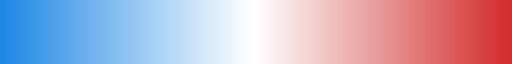

In [57]:
combined_cmap_white

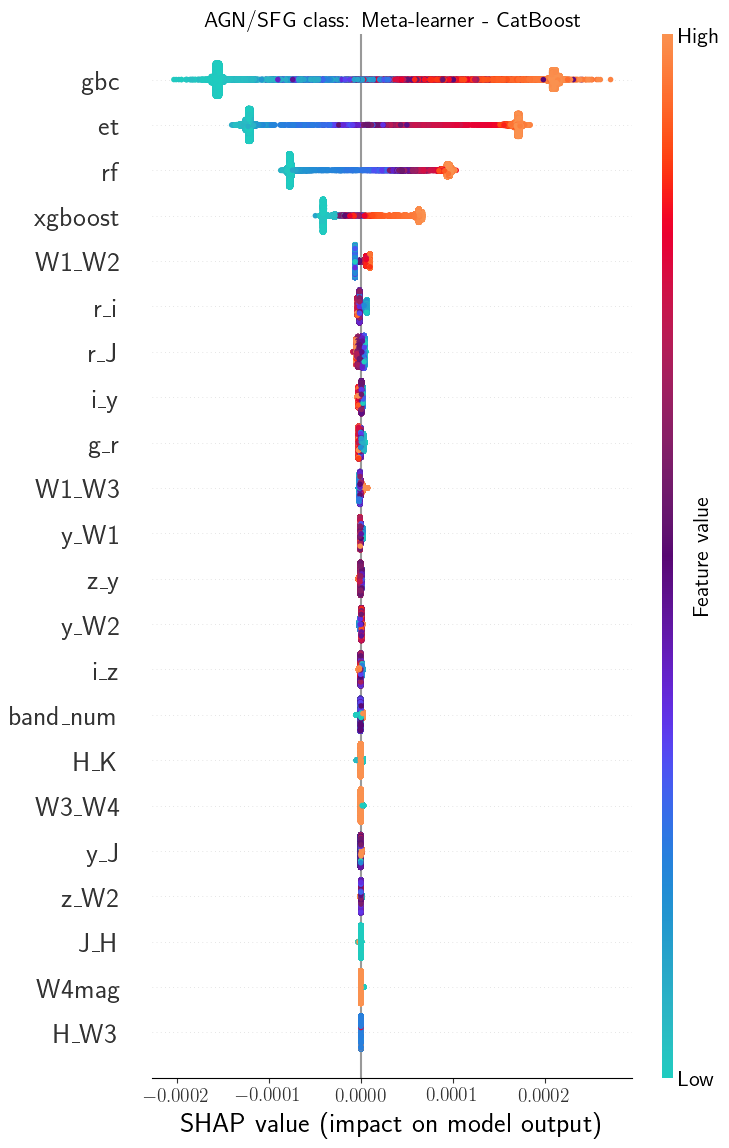

In [58]:
if run_shap_AGN_meta:
    gf.plot_shap_beeswarm('AGN/SFG class', model_name_AGN, shap_values_AGN_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [59]:
new_base_logit_AGN = np.log(gv.AGN_thresh / (1 - gv.AGN_thresh))

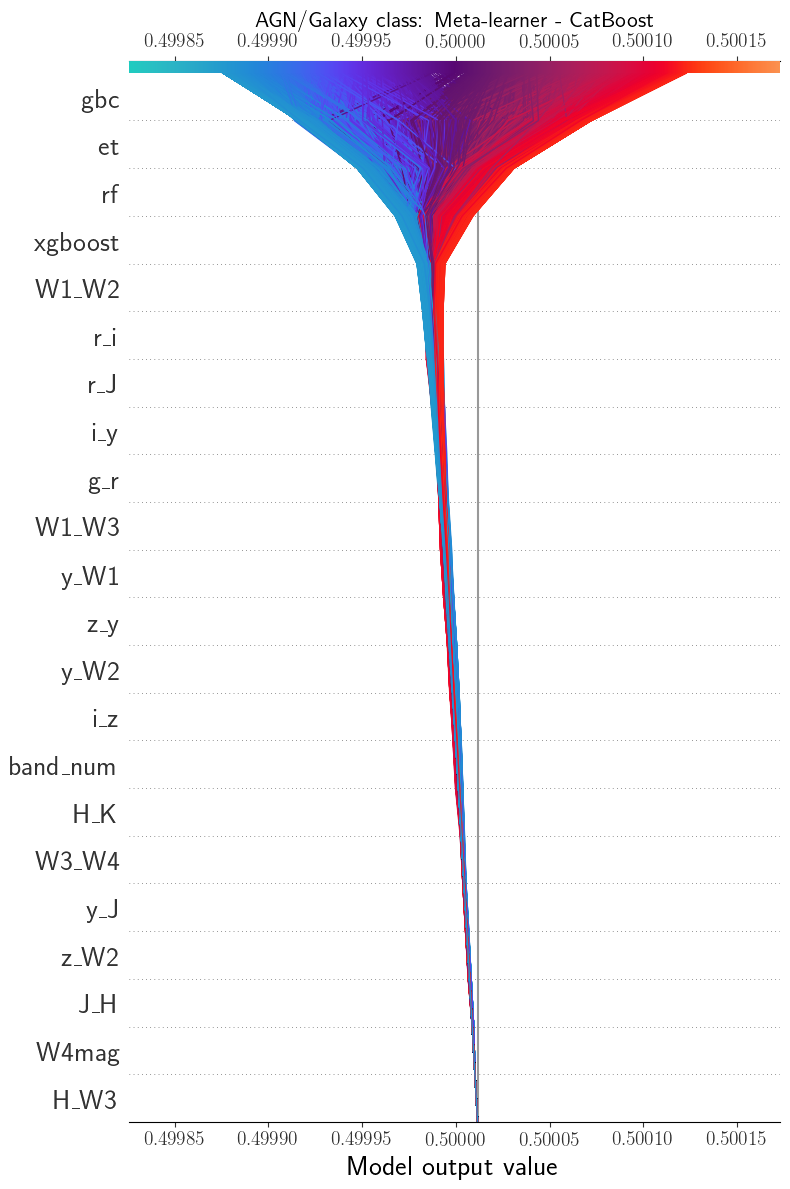

In [60]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.5 - 2.2e-5, 0.5 + 2.1e-5)
if run_shap_AGN_meta:
    xlims_plt_AGN_SFG = (full_catalog_df.loc[reduced_data_AGN_df.index, 'Score_AGN'].min() * 0.9999, 
                         full_catalog_df.loc[reduced_data_AGN_df.index, 'Score_AGN'].max() * 1.0001)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('AGN/Galaxy class', model_name_AGN, shap_values_AGN_meta, explainer_AGN_meta,\
                              reduced_cols_AGN, ax1, 'logit', new_base_value=new_base_logit_AGN,
                              base_meta='Meta', xlim=xlims_plt_AGN_SFG, ignore_warnings=True)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [61]:
if run_shap_AGN_meta:
    sorted_mean_abs_SHAP_AGN = gf.mean_abs_SHAP_meta_model(shap_values_AGN_meta)
    sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'] /\
                                                       sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_AGN.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_AGN = sorted_mean_abs_SHAP_AGN.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_AGN['Cumulative_sum'] = sorted_mean_abs_SHAP_AGN.loc[:, 'Mean_abs_SHAP'].cumsum()

In [62]:
if run_shap_AGN_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,gbc,36.937,36.937
1,et,30.263,67.200
2,rf,18.268,85.468
3,xgboost,9.778,95.246
4,W1_W2,1.476,96.722
5,r_i,0.700,97.422
6,r_J,0.619,98.041
7,i_y,0.319,98.360
8,g_r,0.294,98.654
9,W1_W3,0.281,98.935


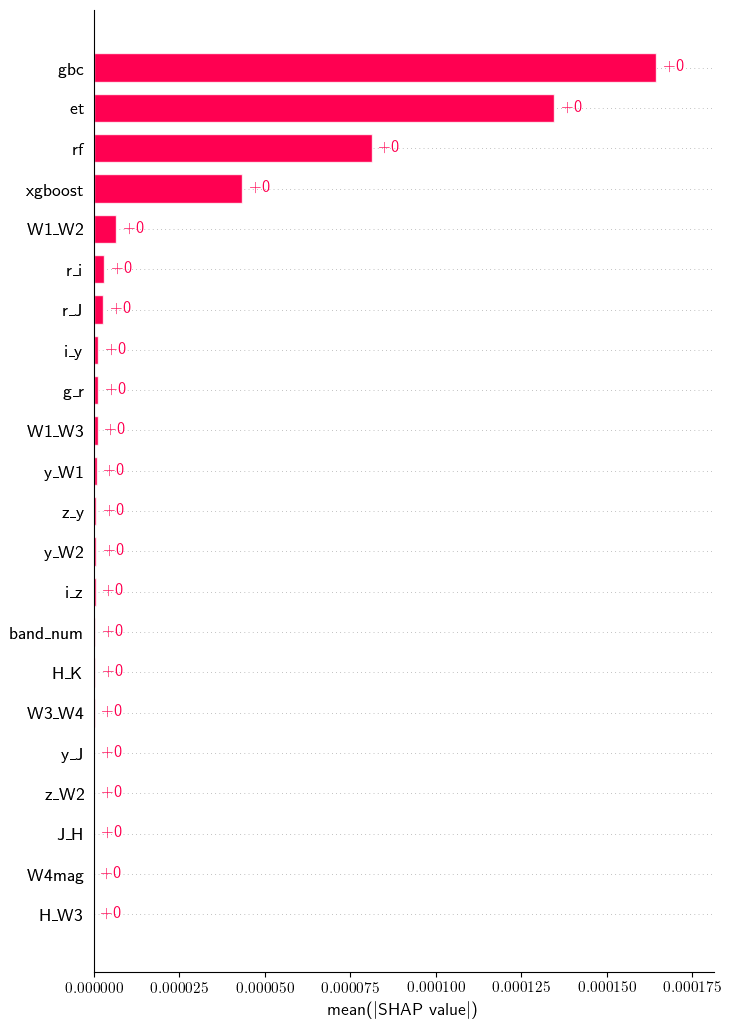

In [63]:
if run_shap_AGN_meta:
    shp_copy_AGN = shap.Explanation(values=shap_values_AGN_meta.values,\
                                    base_values=shap_values_AGN_meta.base_values,\
                                    data=shap_values_AGN_meta.data,\
                                    feature_names=shap_values_AGN_meta.feature_names)
    shap.plots.bar(shap_values=shp_copy_AGN, max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

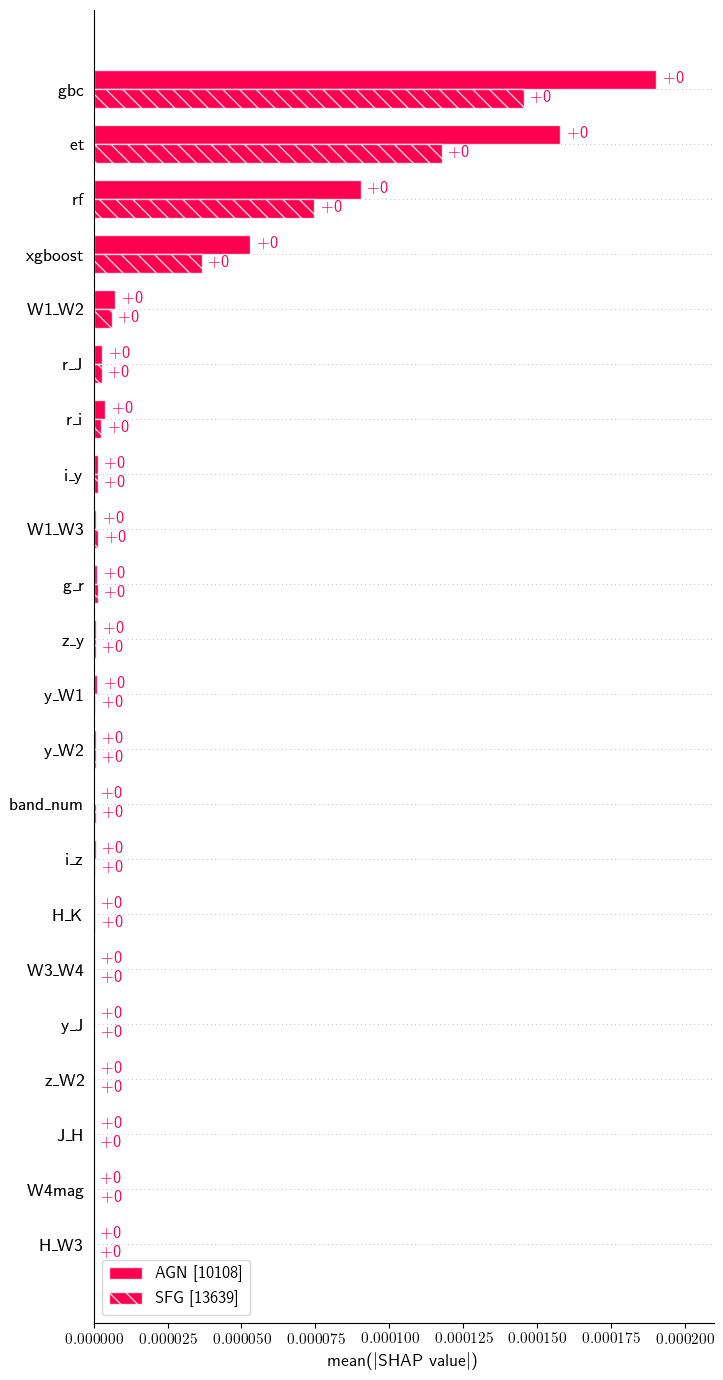

In [64]:
if run_shap_AGN_meta:
    class_AGN    = ['SFG' if elem == 0 else 'AGN' for elem in reduced_data_AGN.loc[:, 'class']]
    shap.plots.bar(shap_values=shp_copy_AGN.cohorts(class_AGN).abs.mean(0), max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [65]:
if run_shap_AGN_meta:
    # The model's raw prediction for the first observation.
    print(AGN_SFG_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_AGN_meta.expected_value + shap_values_AGN_meta.values[0].sum()).round(5))

0
-0.0005


---

#### SHAP - Radio detection model for AGN

In [66]:
if run_shap_radio_meta:
    model_name_radio_AGN = type(radio_det_AGN_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [67]:
np.shape(data_AGN)

(10292, 49)

In [68]:
if run_shap_radio_meta:
    sample_size_radio = 15000
    sample_size_radio = np.nanmin([np.shape(data_AGN)[0], sample_size_radio])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 10,292


In [69]:
if run_shap_radio_meta:
    base_models_names_radio_AGN = gf.get_base_estimators_names(radio_det_AGN_clf)

In [70]:
if run_shap_radio_meta:
    reduced_data_radio_AGN    = data_AGN.sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio_AGN.loc[:, ['LOFAR_detect', 'pred_radio_AGN_cal']].describe())
    reduced_data_radio_AGN_df = gf.preprocess_data(radio_det_AGN_clf, reduced_data_radio_AGN, base_models_names_radio_AGN)
    reduced_cols_radio_AGN    = reduced_data_radio_AGN_df.columns

,LOFAR_detect,pred_radio_AGN_cal
count,10292.000000,10292.000000
mean,0.155072,0.173241
std,0.361991,0.378474
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Use FastTreeSHAP package

In [71]:
if run_shap_radio_meta:
    explainer_radio_AGN_meta = fasttreeshap.TreeExplainer(radio_det_AGN_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=None, feature_perturbation='tree_path_dependent',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [72]:
if run_shap_radio_meta:
    print('Working with meta-model')
    shap_values_radio_AGN_meta = explainer_radio_AGN_meta(reduced_data_radio_AGN_df)

Working with meta-model


In [73]:
if run_shap_radio_meta:
    print(explainer_radio_AGN_meta.expected_value)
    print(np.exp(explainer_radio_AGN_meta.expected_value) / (1 + np.exp(explainer_radio_AGN_meta.expected_value)))

[-2.26360329]
[0.09418251]


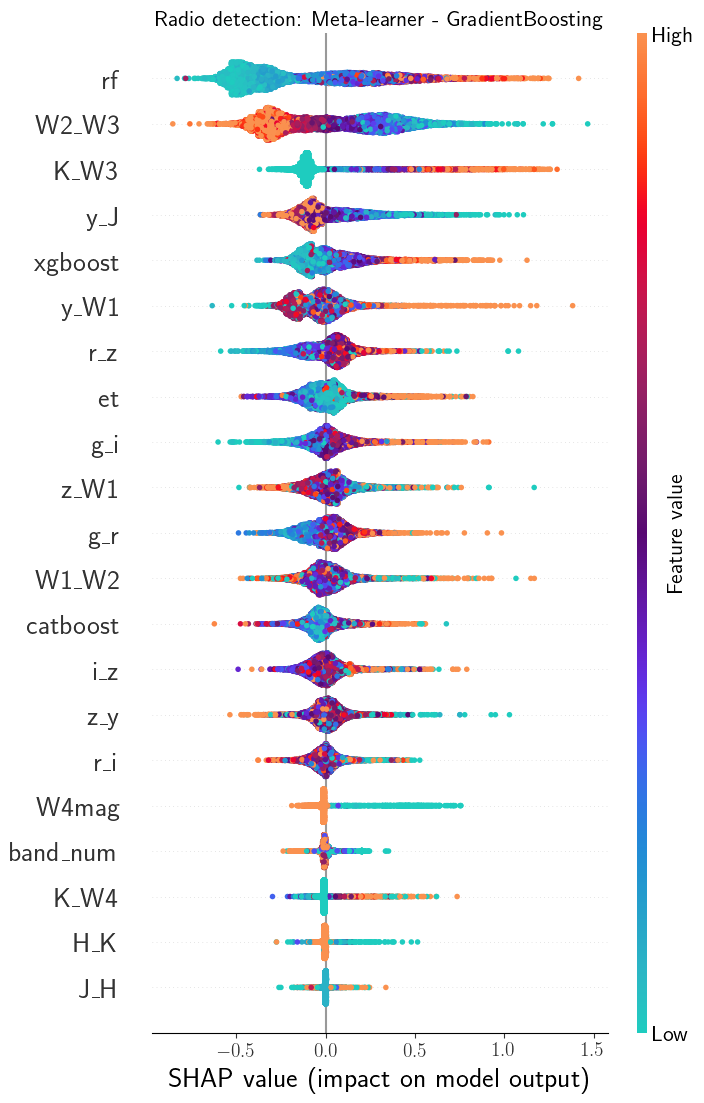

In [74]:
if run_shap_radio_meta:
    gf.plot_shap_beeswarm('Radio detection', model_name_radio_AGN, shap_values_radio_AGN_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [75]:
new_base_logit_radio_AGN = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

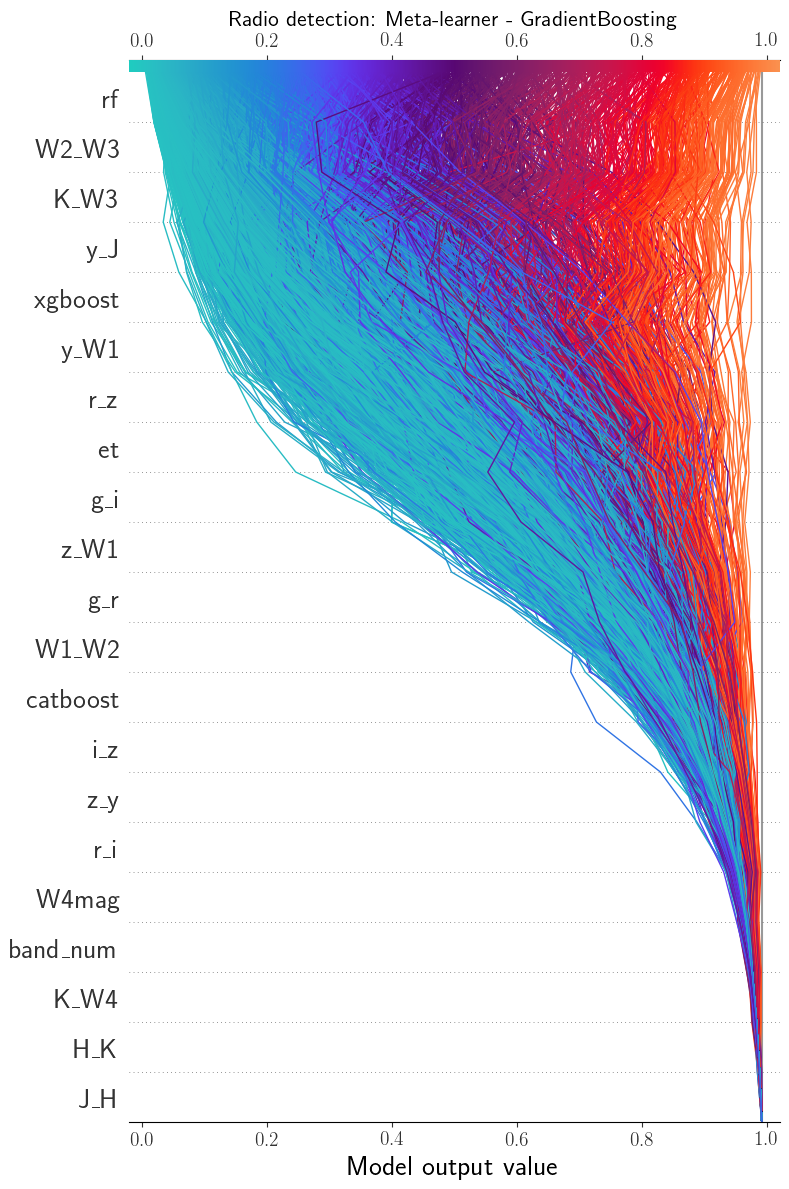

In [76]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_radio_meta:
    xlims_plt       = (data_AGN.loc[reduced_data_radio_AGN_df.index, 'Score_radio_AGN'].min() * 0.99991,\
                       data_AGN.loc[reduced_data_radio_AGN_df.index, 'Score_radio_AGN'].max() * 1.00009)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Radio detection', model_name_radio_AGN, shap_values_radio_AGN_meta,
                              explainer_radio_AGN_meta, reduced_cols_radio_AGN, ax1, 'logit',
                              new_base_value=new_base_logit_radio_AGN, base_meta='Meta', ignore_warnings=True)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [77]:
if run_shap_radio_meta:
    sorted_mean_abs_SHAP_radio_AGN = gf.mean_abs_SHAP_meta_model(shap_values_radio_AGN_meta)
    sorted_mean_abs_SHAP_radio_AGN.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio_AGN.loc[:, 'Mean_abs_SHAP'] /\
                                                         sorted_mean_abs_SHAP_radio_AGN.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_radio_AGN.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_radio_AGN = sorted_mean_abs_SHAP_radio_AGN.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_radio_AGN['Cumulative_sum'] = sorted_mean_abs_SHAP_radio_AGN.loc[:, 'Mean_abs_SHAP'].cumsum()

In [78]:
if run_shap_radio_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_AGN)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,rf,16.961,16.961
1,W2_W3,13.437,30.398
2,K_W3,8.665,39.063
3,y_J,6.350,45.413
4,xgboost,5.872,51.286
5,y_W1,5.097,56.383
6,r_z,4.937,61.320
7,et,4.777,66.096
8,g_i,4.520,70.616
9,z_W1,4.432,75.048


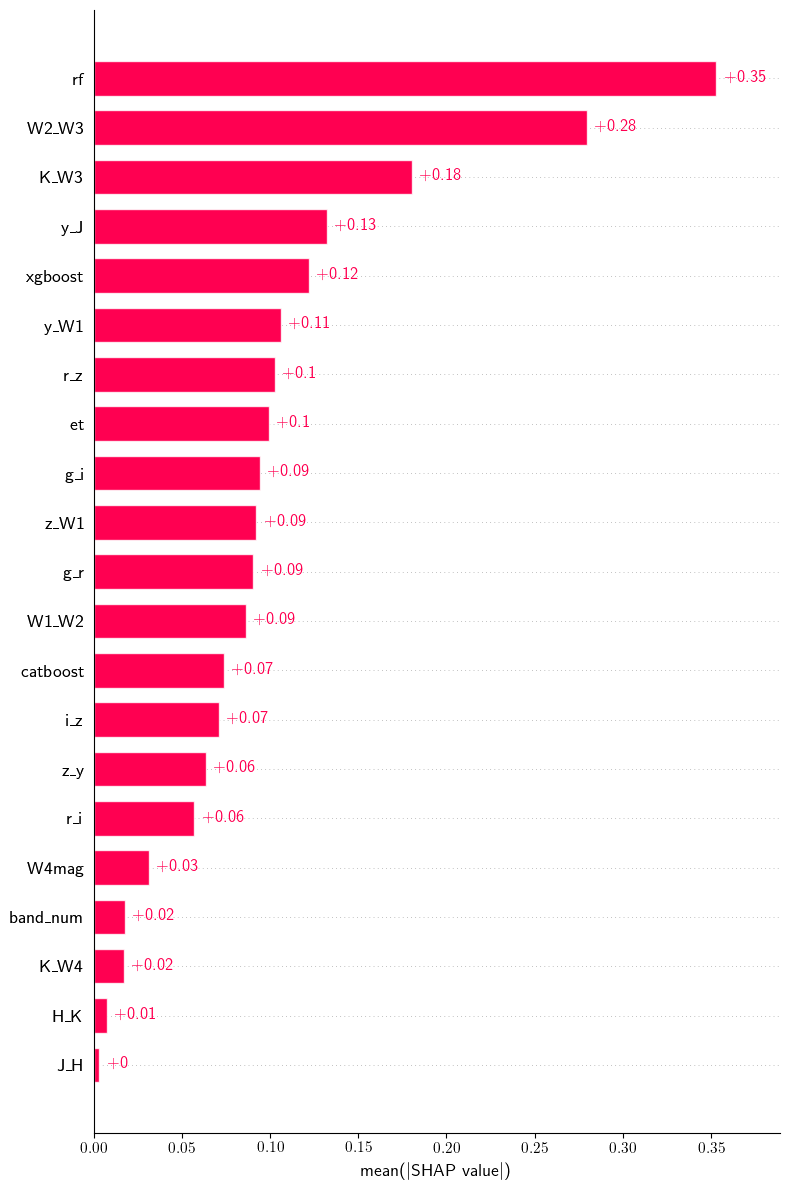

In [79]:
if run_shap_radio_meta:
    shp_copy_radio_AGN = shap.Explanation(values=shap_values_radio_AGN_meta.values,\
                                    base_values=shap_values_radio_AGN_meta.base_values,\
                                    data=shap_values_radio_AGN_meta.data,\
                                    feature_names=shap_values_radio_AGN_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_radio_AGN, max_display=len(shp_copy_radio_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

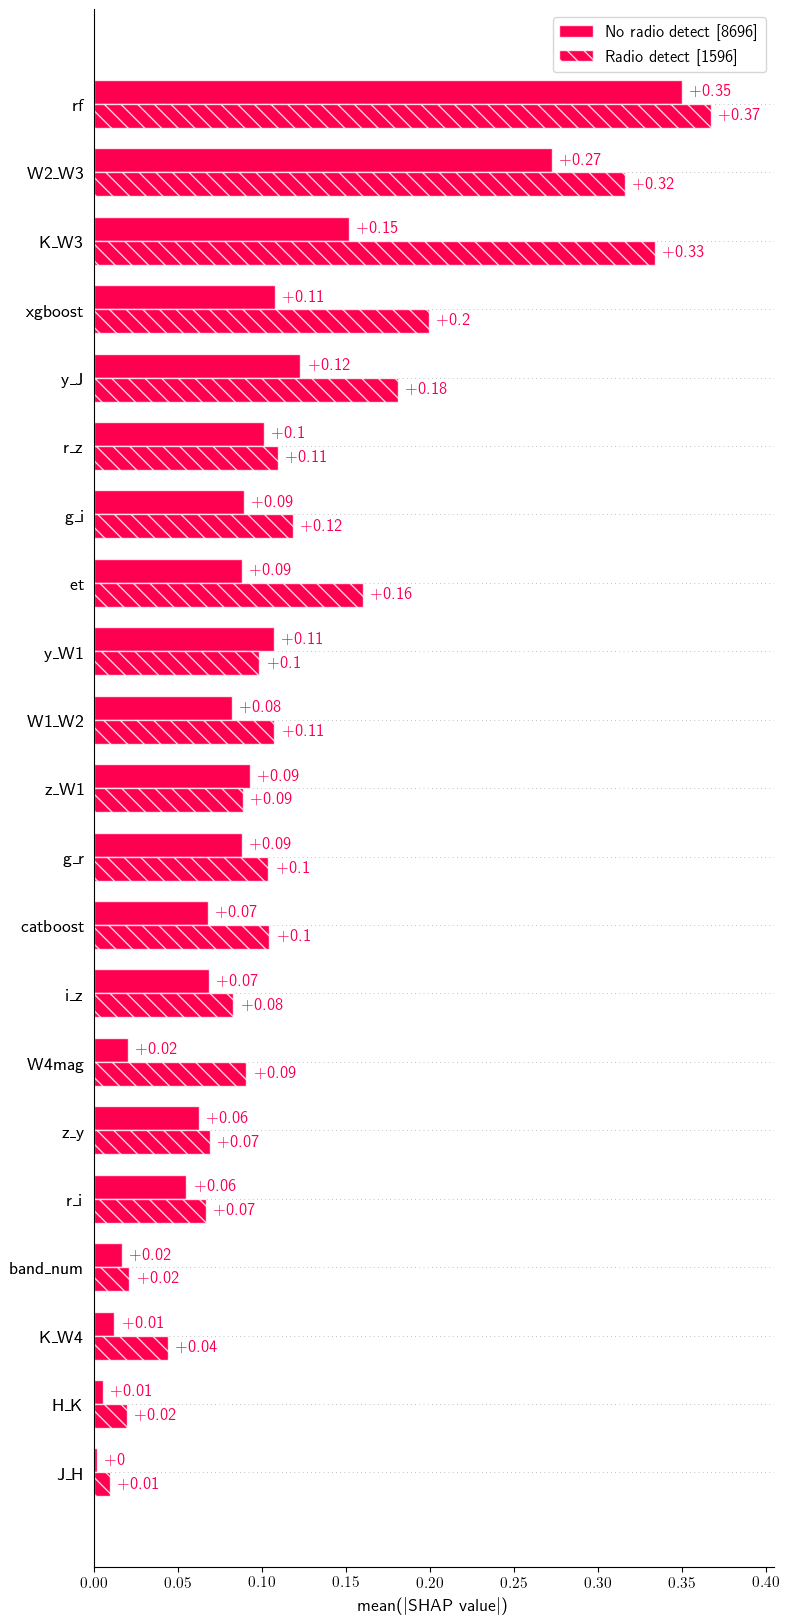

In [80]:
if run_shap_AGN_meta:
    radio_AGN_labels  = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio_AGN.loc[:, 'LOFAR_detect']]
    shap.plots.bar(shap_values=shp_copy_radio_AGN.cohorts(radio_AGN_labels).abs.mean(0), max_display=len(shp_copy_radio_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

In [81]:
if run_shap_radio_meta:
    # The model's raw prediction for the first observation.
    print(radio_det_AGN_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_radio_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_radio_AGN_meta.expected_value + shap_values_radio_AGN_meta.values[0].sum()).round(5))

0
[-2.58517]


#### SHAP - Radio detection model for SFG

In [82]:
if run_shap_radio_meta:
    model_name_radio_SFG = type(radio_det_SFG_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [83]:
np.shape(data_SFG)

(13455, 49)

In [84]:
if run_shap_radio_meta:
    sample_size_radio_SFG = 15000
    sample_size_radio_SFG = np.nanmin([np.shape(data_SFG)[0], sample_size_radio_SFG])
    print(f'Number of selected elements: {sample_size_radio_SFG:,}')

Number of selected elements: 13,455


In [85]:
if run_shap_radio_meta:
    base_models_names_radio_SFG = gf.get_base_estimators_names(radio_det_SFG_clf)

In [86]:
if run_shap_radio_meta:
    reduced_data_radio_SFG    = data_SFG.sample(n=sample_size_radio_SFG, random_state=gv.seed).copy()
    display(reduced_data_radio_SFG.loc[:, ['LOFAR_detect', 'pred_radio_SFG_cal']].describe())
    reduced_data_radio_SFG_df = gf.preprocess_data(radio_det_SFG_clf, reduced_data_radio_SFG, base_models_names_radio_SFG)
    reduced_cols_radio_SFG    = reduced_data_radio_SFG_df.columns

,LOFAR_detect,pred_radio_SFG_cal
count,13455.000000,13455.000000
mean,0.153995,0.149015
std,0.360957,0.356117
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Use FastTreeSHAP package

In [87]:
if run_shap_radio_meta:
    explainer_radio_SFG_meta = fasttreeshap.TreeExplainer(radio_det_SFG_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=None, feature_perturbation='tree_path_dependent',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [88]:
if run_shap_radio_meta:
    print('Working with meta-model')
    shap_values_radio_SFG_meta = explainer_radio_SFG_meta(reduced_data_radio_SFG_df)

Working with meta-model


In [89]:
if run_shap_radio_meta:
    print(explainer_radio_SFG_meta.expected_value)
    print(np.exp(explainer_radio_SFG_meta.expected_value) / (1 + np.exp(explainer_radio_SFG_meta.expected_value)))

[0.5 0.5]
[0.62245933 0.62245933]


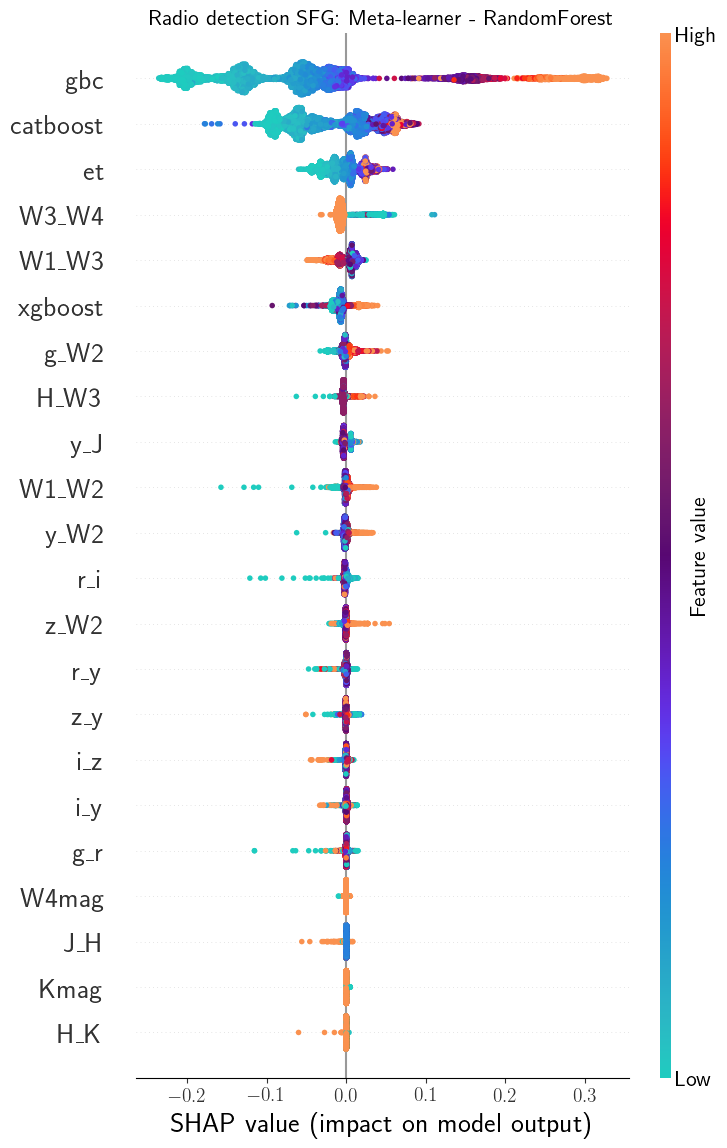

In [90]:
if run_shap_radio_meta:
    gf.plot_shap_beeswarm('Radio detection SFG', model_name_radio_SFG, shap_values_radio_SFG_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_radio_SFG_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [91]:
new_base_logit_radio_SFG = np.log(gv.radio_gals_thresh / (1 - gv.radio_gals_thresh))

<AxesSubplot:>

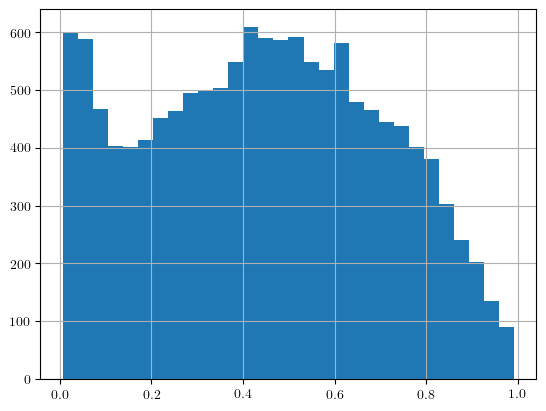

In [92]:
data_SFG.loc[reduced_data_radio_SFG_df.index, 'Score_radio_AGN'].hist(bins=30)

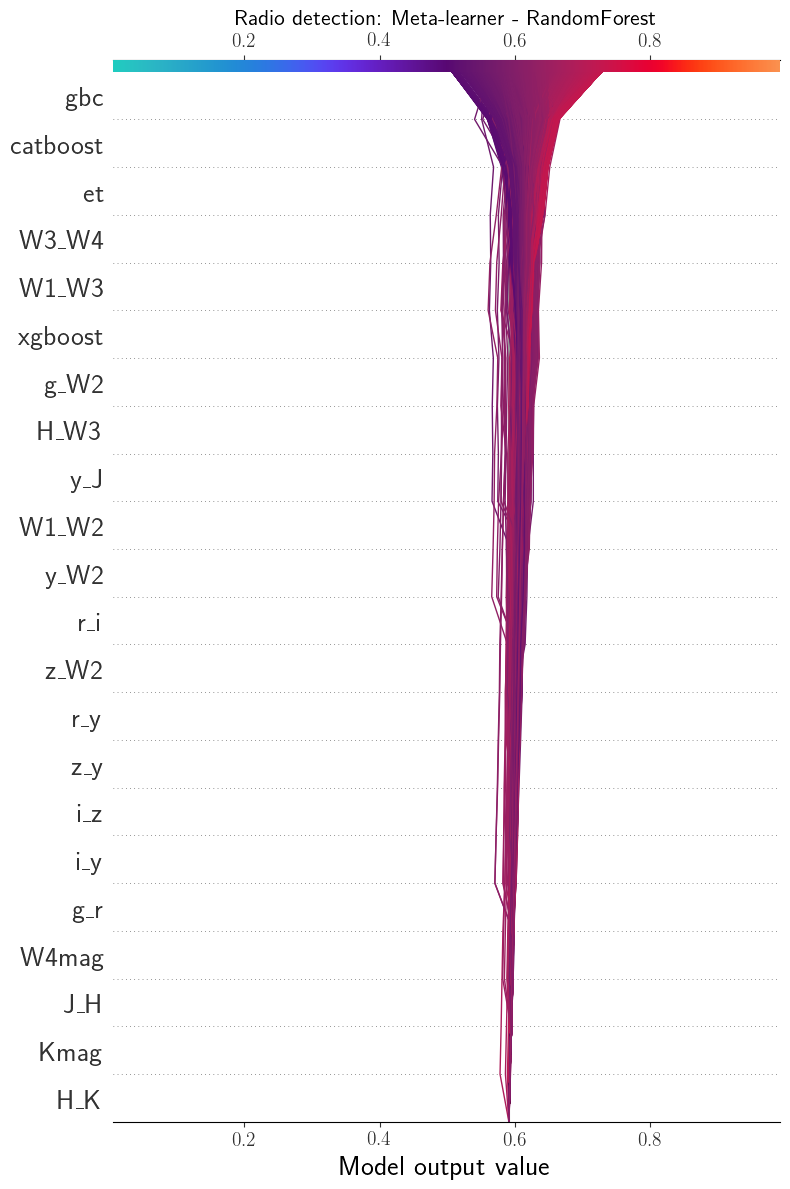

In [93]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_radio_meta:
    xlims_plt_radio_SFG  = (data_SFG.loc[reduced_data_radio_SFG_df.index, 'Score_radio_AGN'].min() * 0.99991,\
                       data_SFG.loc[reduced_data_radio_SFG_df.index, 'Score_radio_AGN'].max() * 1.00009)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Radio detection', model_name_radio_SFG, shap_values_radio_SFG_meta,
                              explainer_radio_SFG_meta, reduced_cols_radio_SFG, ax1,
                              'logit', new_base_value=new_base_logit_radio_SFG, xlim=xlims_plt_radio_SFG,
                              base_meta='Meta', ignore_warnings=True)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_radio_SFG_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [94]:
if run_shap_radio_meta:
    sorted_mean_abs_SHAP_radio_SFG = gf.mean_abs_SHAP_meta_model(shap_values_radio_SFG_meta)
    sorted_mean_abs_SHAP_radio_SFG.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio_SFG.loc[:, 'Mean_abs_SHAP'] /\
                                                         sorted_mean_abs_SHAP_radio_SFG.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_radio_SFG.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_SFG_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_radio_SFG = sorted_mean_abs_SHAP_radio_SFG.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_radio_SFG['Cumulative_sum'] = sorted_mean_abs_SHAP_radio_SFG.loc[:, 'Mean_abs_SHAP'].cumsum()

In [95]:
if run_shap_radio_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_SFG)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,gbc,45.457,45.457
1,catboost,21.595,67.053
2,et,7.719,74.771
3,W3_W4,4.532,79.304
4,W1_W3,4.399,83.702
5,xgboost,4.395,88.098
6,g_W2,2.281,90.379
7,H_W3,1.886,92.264
8,y_J,1.684,93.948
9,W1_W2,1.158,95.106


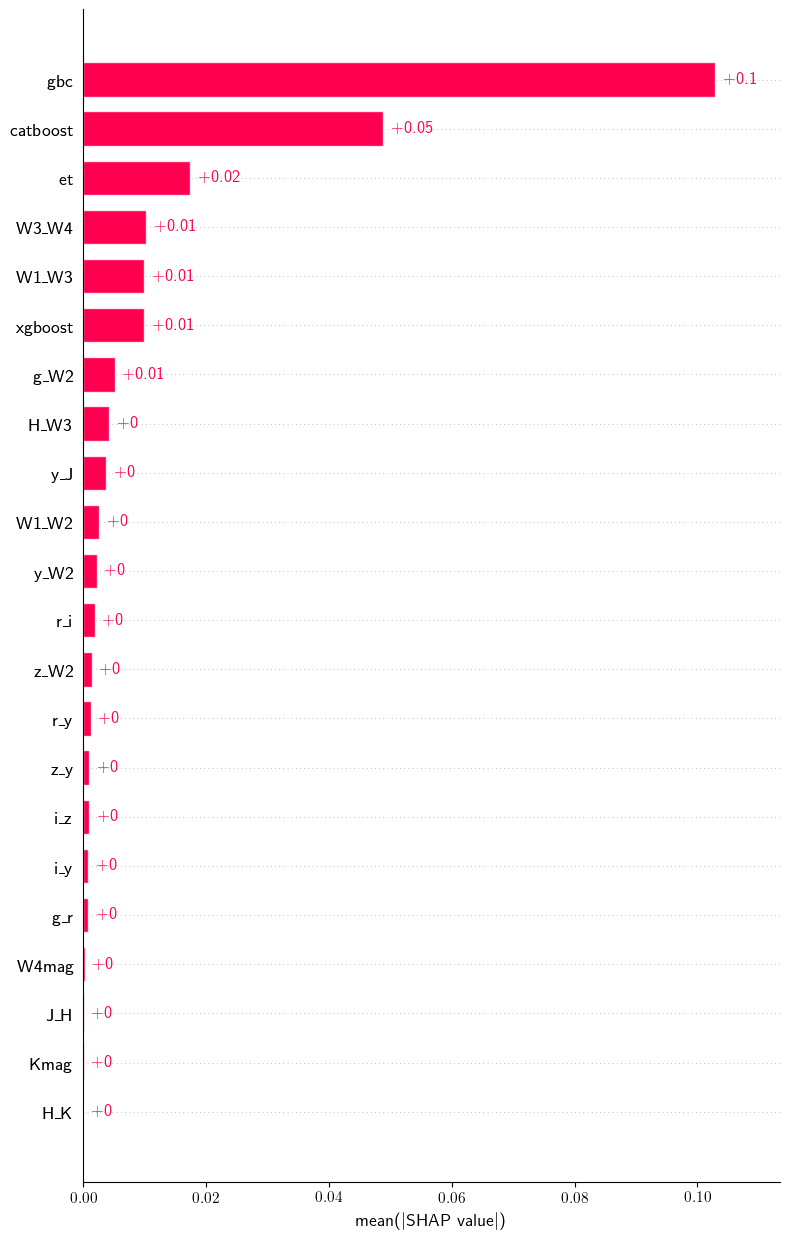

In [96]:
if run_shap_radio_meta:
    shp_copy_radio_SFG = shap.Explanation(values=shap_values_radio_SFG_meta.values[:, :, 1],
                                          base_values=shap_values_radio_SFG_meta.base_values,
                                          data=shap_values_radio_SFG_meta.data,
                                          feature_names=shap_values_radio_SFG_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_radio_SFG, max_display=len(shp_copy_radio_SFG.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

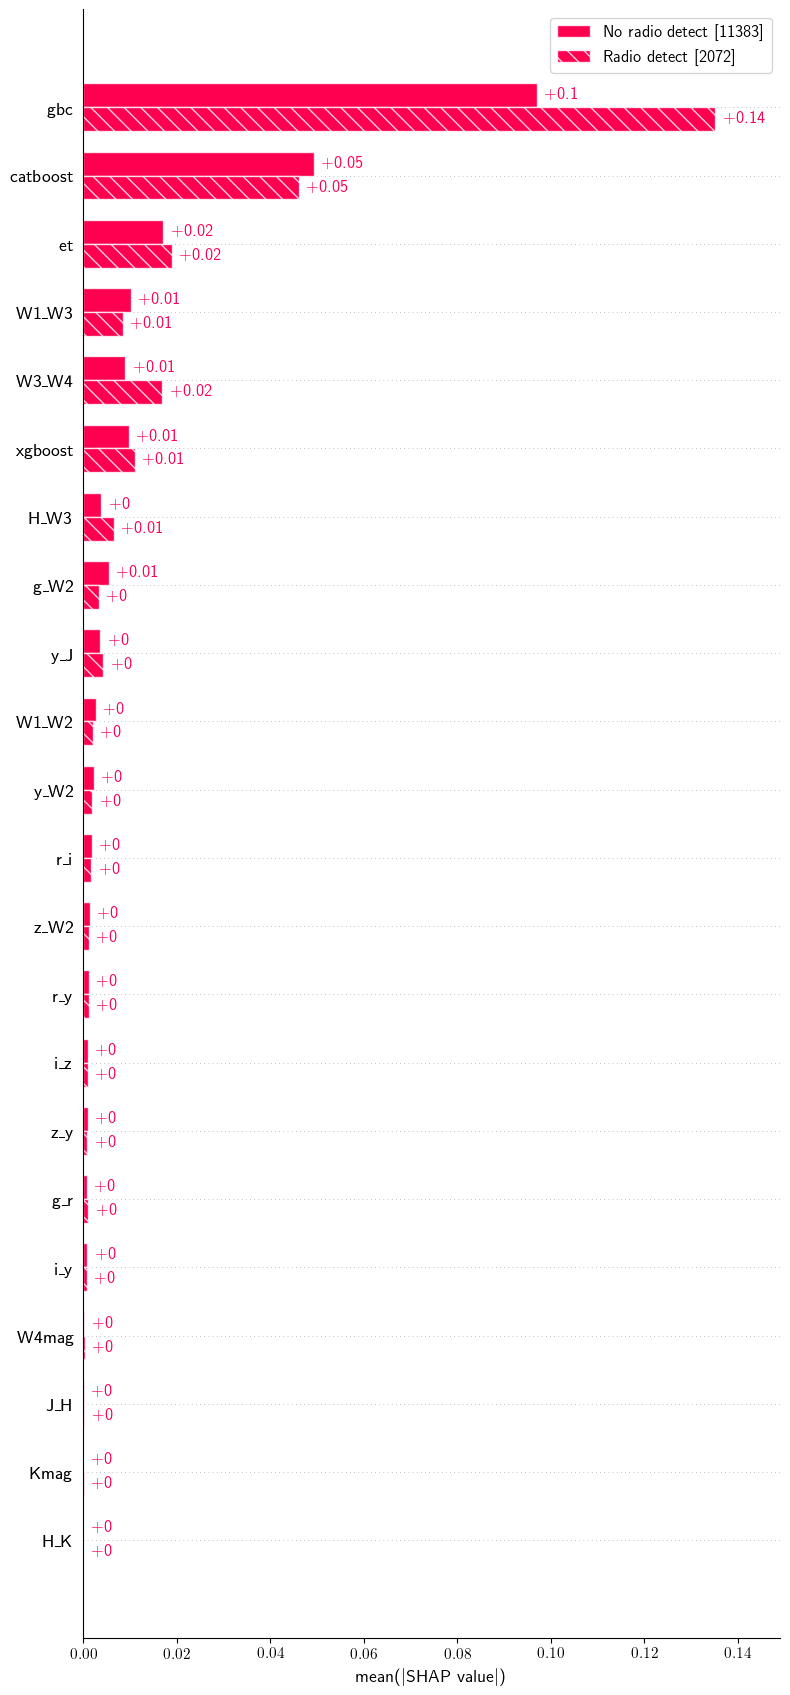

In [97]:
if run_shap_radio_meta:
    radio_SFG_labels  = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio_SFG.loc[:, 'LOFAR_detect']]
    shap.plots.bar(shap_values=shp_copy_radio_SFG.cohorts(radio_SFG_labels).abs.mean(0), max_display=len(shp_copy_radio_SFG.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.tight_layout()
    plt.show()

In [98]:
if run_shap_radio_meta:
    # The model's raw prediction for the first observation.
    print(radio_det_SFG_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_radio_SFG_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_radio_SFG_meta.expected_value + shap_values_radio_SFG_meta.values[0].sum()).round(5))

1
[0.5 0.5]


---

#### SHAP - Radio AGN redshift prediction model

In [99]:
if run_shap_z_meta:
    model_name_z_AGN = type(redshift_reg_rAGN.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [100]:
np.shape(data_radio_AGN)

(1783, 49)

In [101]:
if run_shap_z_meta:
    sample_size_z_AGN    = 2500
    sample_size_z_AGN    = np.nanmin([sample_size_z_AGN, np.shape(data_radio_AGN)[0]])
    print(f'Number of selected elements: {sample_size_z_AGN:,}')

Number of selected elements: 1,783


In [102]:
if run_shap_z_meta:
    base_models_names_z_AGN = gf.get_base_estimators_names(redshift_reg_rAGN)

In [103]:
if run_shap_z_meta:
    reduced_data_z_AGN    = data_radio_AGN.sample(n=sample_size_z_AGN, random_state=gv.seed).copy()
    display(reduced_data_z_AGN.loc[:, ['Z', 'pred_Z_rAGN']].describe())
    reduced_data_z_AGN_df = gf.preprocess_data(redshift_reg_rAGN, reduced_data_z_AGN, base_models_names_z_AGN)
    reduced_cols_z_AGN    = reduced_data_z_AGN_df.columns

,Z,pred_Z_rAGN
count,1783.000000,1783.000000
mean,1.188179,1.250772
std,0.831846,0.772785
min,0.000000,0.022300
25%,0.502000,0.643550
50%,1.070000,1.156600
75%,1.751000,1.842450
max,4.738000,4.514300


Use FastTreeSHAP package

In [104]:
if run_shap_z_meta:
    explainer_z_AGN_meta = fasttreeshap.TreeExplainer(redshift_reg_rAGN.named_steps['trained_model'].final_estimator_,
                                                      data=None, feature_perturbation='tree_path_dependent',
                                                      model_output='raw', feature_dependence='independent',
                                                      algorithm='auto', n_jobs=12)

In [105]:
if run_shap_z_meta:
    print('Working with meta-model')
    shap_values_z_AGN_meta = explainer_z_AGN_meta(reduced_data_z_AGN_df)

Working with meta-model


In [106]:
if run_shap_z_meta:
    print(explainer_z_AGN_meta.expected_value)

[1.3242504]


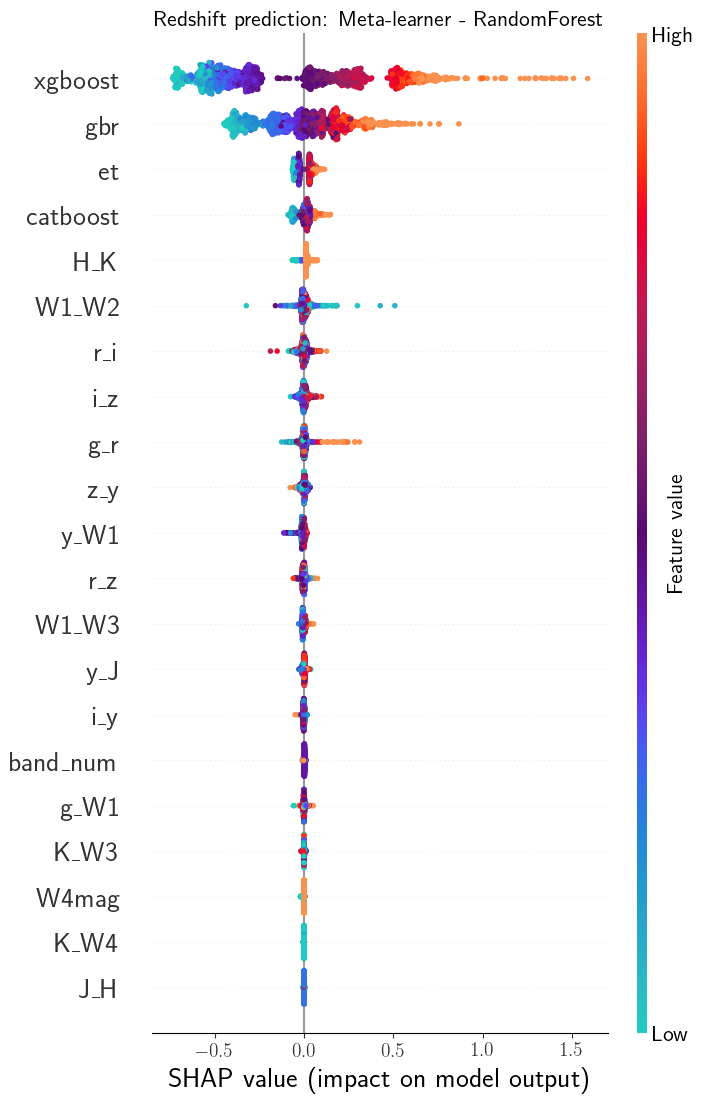

In [107]:
if run_shap_z_meta:
    gf.plot_shap_beeswarm('Redshift prediction', model_name_z_AGN, shap_values_z_AGN_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_z_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

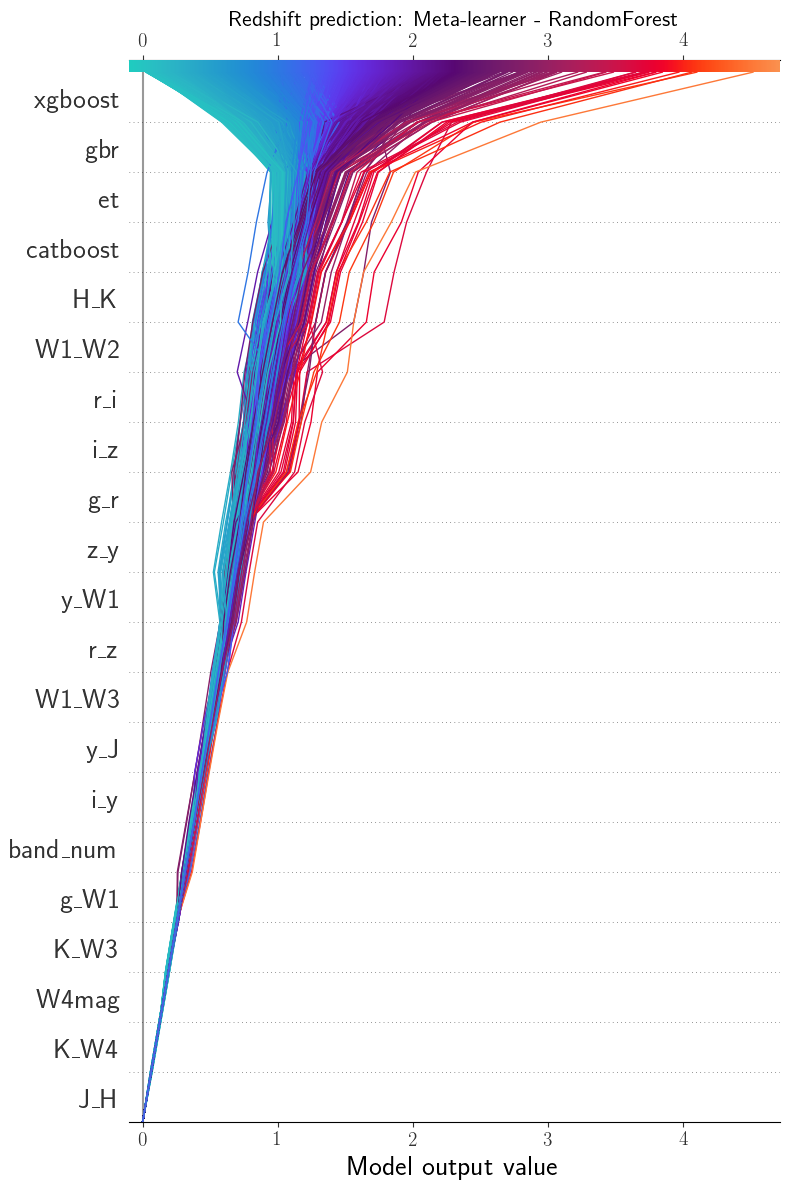

In [108]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_z_meta:
    xlims_plt_z_AGN = (-0.1,\
                       data_radio_AGN.loc[reduced_data_z_AGN_df.index, 'pred_Z_rAGN'].max() + 0.2)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Redshift prediction', model_name_z_AGN, shap_values_z_AGN_meta, explainer_z_AGN_meta,\
                              reduced_cols_z_AGN, ax1, 'identity', new_base_value=0.0, base_meta='Meta', xlim=xlims_plt_z_AGN)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_z_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [109]:
if run_shap_z_meta:
    sorted_mean_abs_SHAP_z_AGN = gf.mean_abs_SHAP_meta_model(shap_values_z_AGN_meta)
    sorted_mean_abs_SHAP_z_AGN.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z_AGN.loc[:, 'Mean_abs_SHAP'] /\
                                                     sorted_mean_abs_SHAP_z_AGN.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_z_AGN.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_z_AGN = sorted_mean_abs_SHAP_z_AGN.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_z_AGN['Cumulative_sum'] = sorted_mean_abs_SHAP_z_AGN.loc[:, 'Mean_abs_SHAP'].cumsum()

In [110]:
if run_shap_z_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_AGN)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,xgboost,52.225,52.225
1,gbr,23.487,75.712
2,et,5.182,80.894
3,catboost,3.848,84.742
4,H_K,2.516,87.258
5,W1_W2,1.969,89.227
6,r_i,1.888,91.115
7,i_z,1.608,92.724
8,g_r,1.503,94.226
9,z_y,1.096,95.322


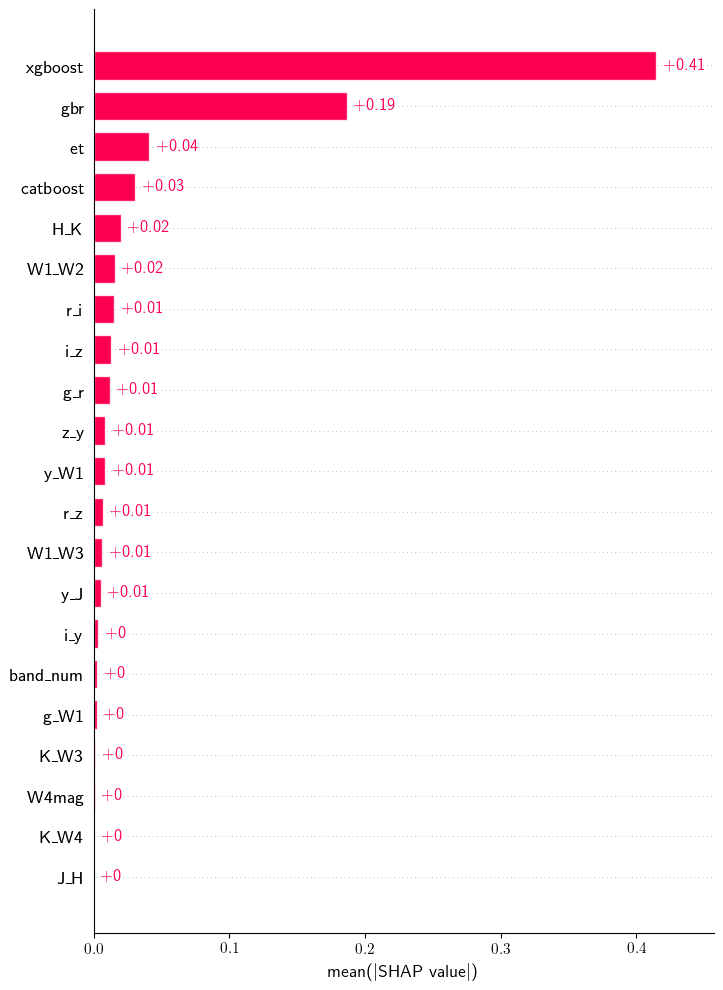

In [111]:
if run_shap_z_meta:
    shp_copy_z_AGN = shap.Explanation(values=shap_values_z_AGN_meta.values,
                                      base_values=shap_values_z_AGN_meta.base_values,
                                      data=shap_values_z_AGN_meta.data,
                                      feature_names=shap_values_z_AGN_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_z_AGN, max_display=len(shp_copy_z_AGN.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [112]:
if run_shap_z_meta:
    # The model's raw prediction for the first observation.
    print(redshift_reg_rAGN.named_steps['trained_model'].final_estimator_.predict(reduced_data_z_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_z_AGN_meta.expected_value + shap_values_z_AGN_meta.values[0].sum()).round(5))

2.02274
[2.02274]


#### SHAP - Radio SFG redshift prediction model

In [113]:
if run_shap_z_meta:
    model_name_z_SFG = type(redshift_reg_rSFG.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [114]:
np.shape(data_radio_SFG)

(2005, 49)

In [115]:
if run_shap_z_meta:
    sample_size_z_SFG    = 2500
    sample_size_z_SFG    = np.nanmin([sample_size_z_SFG, np.shape(data_radio_SFG)[0]])
    print(f'Number of selected elements: {sample_size_z_SFG:,}')

Number of selected elements: 2,005


In [116]:
if run_shap_z_meta:
    base_models_names_z_SFG = gf.get_base_estimators_names(redshift_reg_rSFG)

In [117]:
if run_shap_z_meta:
    reduced_data_z_SFG    = data_radio_SFG.sample(n=sample_size_z_SFG, random_state=gv.seed).copy()
    display(reduced_data_z_SFG.loc[:, ['Z', 'pred_Z_rSFG']].describe())
    reduced_data_z_SFG_df = gf.preprocess_data(redshift_reg_rSFG, reduced_data_z_SFG, base_models_names_z_SFG)
    reduced_cols_z_SFG    = reduced_data_z_SFG_df.columns

,Z,pred_Z_rSFG
count,2005.000000,2005.000000
mean,0.334220,0.336274
std,0.289564,0.247394
min,0.000000,0.021400
25%,0.106000,0.107200
50%,0.255050,0.277000
75%,0.532020,0.558500
max,4.680000,1.272300


Use FastTreeSHAP package

In [118]:
if run_shap_z_meta:
    explainer_z_SFG_meta = fasttreeshap.TreeExplainer(redshift_reg_rSFG.named_steps['trained_model'].final_estimator_,
                                                      data=None, feature_perturbation='tree_path_dependent',
                                                      model_output='raw', feature_dependence='independent',
                                                      algorithm='auto', n_jobs=12)

In [119]:
if run_shap_z_meta:
    print('Working with meta-model')
    shap_values_z_SFG_meta = explainer_z_SFG_meta(reduced_data_z_SFG_df)

Working with meta-model


In [120]:
if run_shap_z_meta:
    print(explainer_z_SFG_meta.expected_value)

[0.40927341]


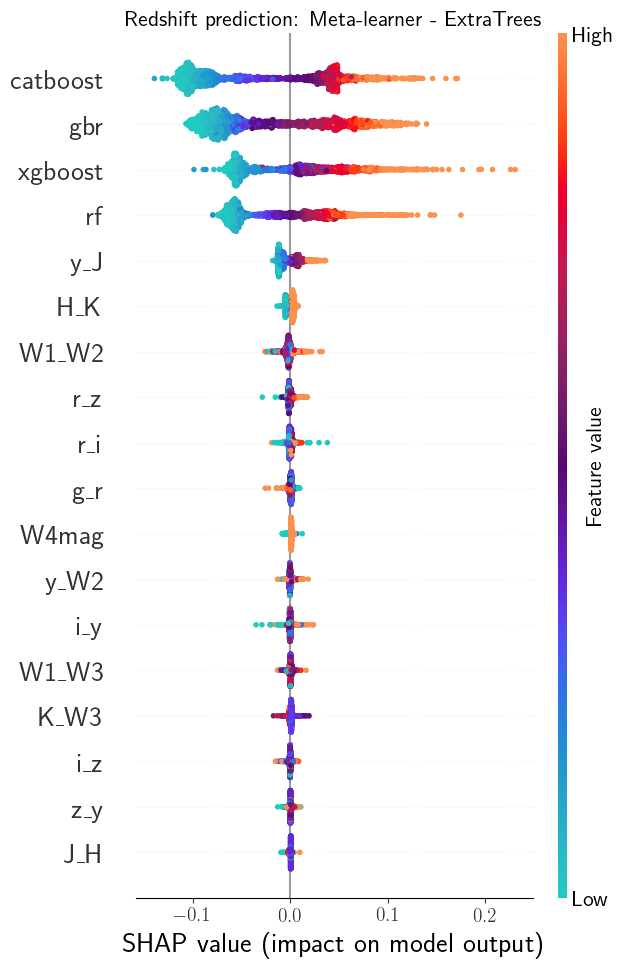

In [121]:
if run_shap_z_meta:
    gf.plot_shap_beeswarm('Redshift prediction', model_name_z_SFG, shap_values_z_SFG_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_z_SFG_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

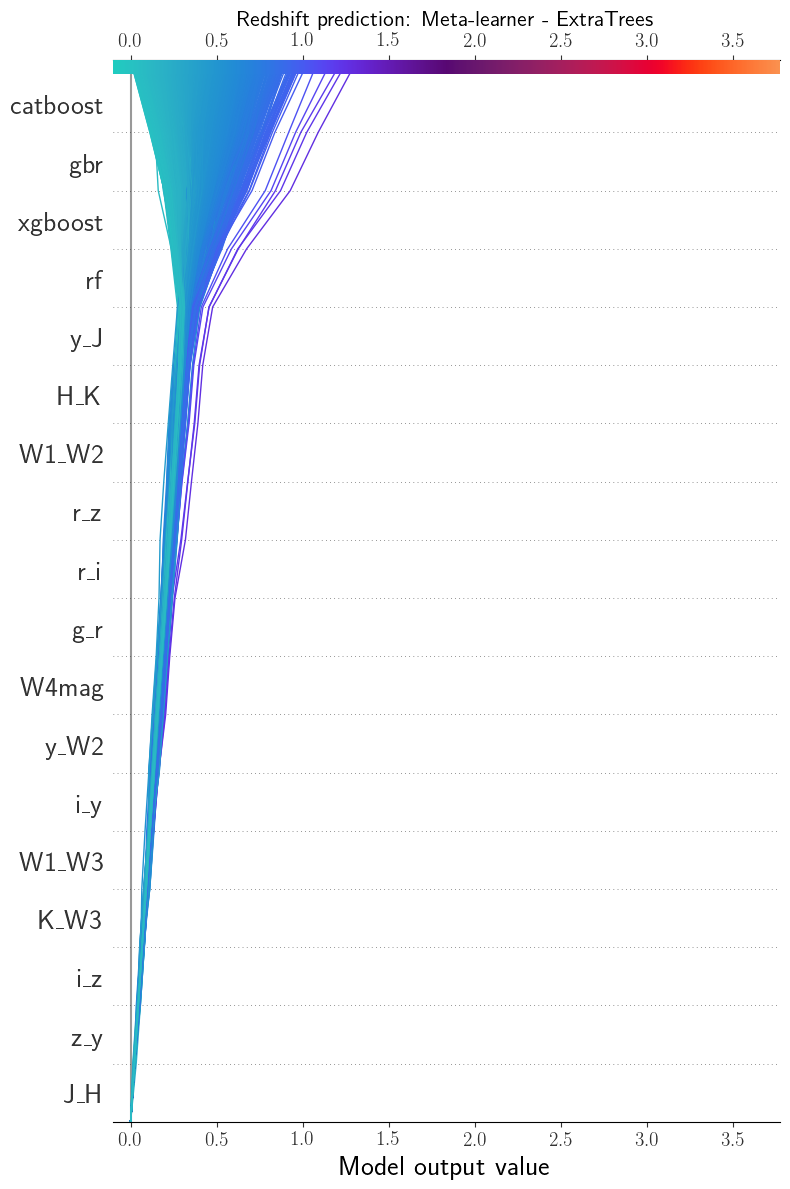

In [122]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_z_meta:
    xlims_plt_z_SFG = (-0.1,\
                       data_radio_SFG.loc[reduced_data_z_SFG_df.index, 'pred_Z_rAGN'].max() + 0.2)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Redshift prediction', model_name_z_SFG, shap_values_z_SFG_meta,
                              explainer_z_SFG_meta, reduced_cols_z_SFG, ax1, 'identity',
                              new_base_value=0.0, base_meta='Meta', xlim=xlims_plt_z_SFG, ignore_warnings=True)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_z_SFG_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [123]:
if run_shap_z_meta:
    sorted_mean_abs_SHAP_z_SFG = gf.mean_abs_SHAP_meta_model(shap_values_z_SFG_meta)
    sorted_mean_abs_SHAP_z_SFG.loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z_SFG.loc[:, 'Mean_abs_SHAP'] /\
                                                     sorted_mean_abs_SHAP_z_SFG.loc[:, 'Mean_abs_SHAP'].sum() * 100
    sorted_mean_abs_SHAP_z_SFG.to_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_SFG_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')
    sorted_mean_abs_SHAP_z_SFG = sorted_mean_abs_SHAP_z_SFG.sort_values(by=['Mean_abs_SHAP'], ascending=False)
    sorted_mean_abs_SHAP_z_SFG['Cumulative_sum'] = sorted_mean_abs_SHAP_z_SFG.loc[:, 'Mean_abs_SHAP'].cumsum()

In [124]:
if run_shap_z_meta:
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_SFG)

Mean absolute SHAP values scaled to sum 100


,Feature,Mean_abs_SHAP,Cumulative_sum
0,catboost,27.865,27.865
1,gbr,24.854,52.719
2,xgboost,18.266,70.985
3,rf,17.835,88.820
4,y_J,3.396,92.216
5,H_K,1.369,93.585
6,W1_W2,1.270,94.856
7,r_z,0.685,95.541
8,r_i,0.640,96.181
9,g_r,0.566,96.747


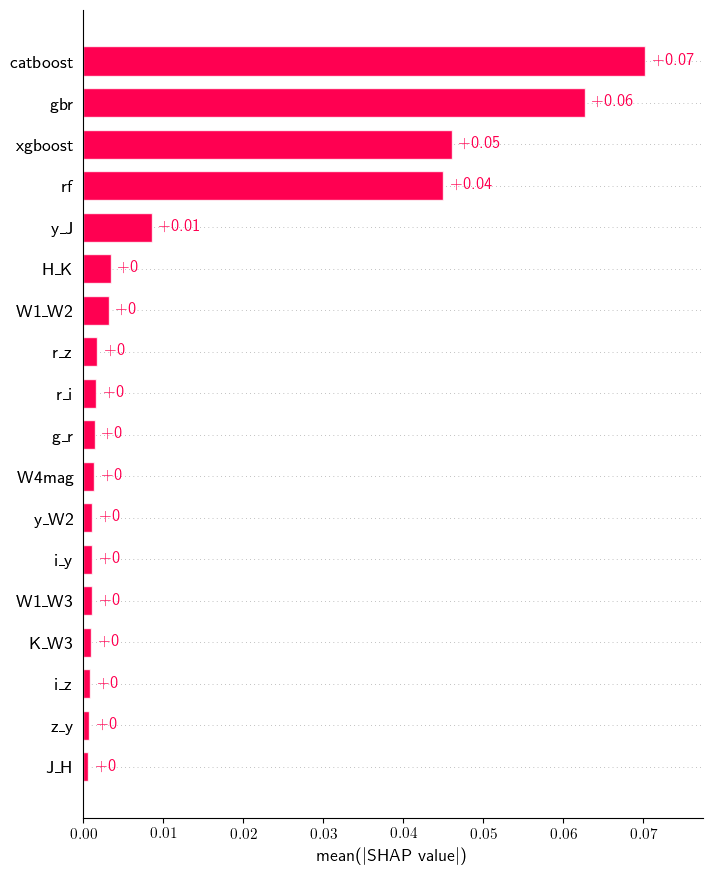

In [125]:
if run_shap_z_meta:
    shp_copy_z_SFG = shap.Explanation(values=shap_values_z_SFG_meta.values,
                                      base_values=shap_values_z_SFG_meta.base_values,
                                      data=shap_values_z_SFG_meta.data,
                                      feature_names=shap_values_z_SFG_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_z_SFG, max_display=len(shp_copy_z_SFG.feature_names), show=False)
    plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
    plt.show()

In [126]:
if run_shap_z_meta:
    # The model's raw prediction for the first observation.
    print(redshift_reg_rSFG.named_steps['trained_model'].final_estimator_.predict(reduced_data_z_SFG_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_z_SFG_meta.expected_value + shap_values_z_SFG_meta.values[0].sum()).round(5))

0.4986
[0.4986]
